In [39]:
!pip install torch torchvision pycocotools matplotlib  # install dependencies

import os
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Paths (adjust as needed)
data_dir = 'data/lhsealine_pipe_seg_train_coco'
images_dir = os.path.join(data_dir, 'images/Train')
ann_file = os.path.join(data_dir, 'annotations/instances_Train.json')

# Load COCO annotations
coco = COCO(ann_file)  # parse COCO JSON
img_ids = coco.getImgIds()
print(f"Found {len(img_ids)} annotated images in COCO JSON.")


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 100 annotated images in COCO JSON.


In [40]:
# Example: create a mask for one image
img_id = img_ids[0]
anns_ids = coco.getAnnIds(imgIds=img_id, iscrowd=None)
anns = coco.loadAnns(anns_ids)

# Load image to get its size
img_info = coco.loadImgs(img_id)[0]
img_path = os.path.join(images_dir, img_info['file_name'])
with Image.open(img_path) as img:
    width, height = img.size

# Initialize mask
mask = np.zeros((height, width), dtype=np.uint8)
# Accumulate each annotation’s mask
for ann in anns:
    mask += coco.annToMask(ann)
# Convert to binary (0 or 1)
mask = (mask > 0).astype(np.uint8)


In [41]:
import torchvision.transforms as T

class PipeSegmentationDataset(Dataset):
    def __init__(self, images_dir, coco, transforms=None):
        self.images_dir = images_dir
        self.coco = coco
        self.ids = coco.getImgIds()
        self.transforms = transforms

    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.images_dir, img_info['file_name'])
        # Load image
        img = Image.open(img_path).convert('RGB')
        img = T.ToTensor()(img)  # convert to [C,H,W] tensor, normalized [0,1]
        
        # Create mask as above
        anns_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anns = self.coco.loadAnns(anns_ids)
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in anns:
            mask += self.coco.annToMask(ann)
        mask = (mask > 0).astype(np.uint8)
        mask = torch.from_numpy(mask).unsqueeze(0).float()  # 1xHxW tensor
        
        # Optionally apply same transforms (none here besides ToTensor)
        if self.transforms:
            img = self.transforms(img)
            mask = self.transforms(mask)
        return img, mask

# Create dataset and dataloader (use small batch size to avoid CUDA OOM)
dataset = PipeSegmentationDataset(images_dir, coco)
loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
print(f"Dataset size: {len(dataset)} images.")


Dataset size: 100 images.


In [42]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """[Conv => ReLU] x 2 block."""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128]):
        super().__init__()
        # Encoder path
        self.downs = nn.ModuleList()
        self.pools = nn.ModuleList()
        prev_ch = in_channels
        for ch in features:
            self.downs.append(DoubleConv(prev_ch, ch))
            self.pools.append(nn.MaxPool2d(2))
            prev_ch = ch
        # Bottleneck
        self.bottleneck = DoubleConv(prev_ch, prev_ch * 2)
        prev_ch = prev_ch * 2  # channels after bottleneck
        # Decoder path
        self.ups = nn.ModuleList()
        self.up_convs = nn.ModuleList()
        for ch in reversed(features):
            # up-convolution reduces channels from prev_ch to ch
            self.up_convs.append(nn.ConvTranspose2d(prev_ch, ch, kernel_size=2, stride=2))
            # DoubleConv sees concatenated [skip, upsampled] => 2 * ch input channels
            self.ups.append(DoubleConv(ch * 2, ch))
            prev_ch = ch
        # Final 1x1 conv to get desired output channels
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    def forward(self, x):
        skip_connections = []
        # Encoder
        for down, pool in zip(self.downs, self.pools):
            x = down(x)
            skip_connections.append(x)
            x = pool(x)
        # Bottleneck
        x = self.bottleneck(x)
        # Decoder
        for up_conv, up in zip(self.up_convs, self.ups):
            x = up_conv(x)  # upsample
            skip = skip_connections.pop()
            # If needed, pad or crop skip to match size
            if x.shape != skip.shape:
                skip = F.interpolate(skip, size=x.shape[2:]) 
            x = torch.cat([skip, x], dim=1)
            x = up(x)
        return self.final_conv(x)

# Instantiate model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, out_channels=1).to(device)
print(model)


UNet(
  (downs): ModuleList(
    (0): DoubleConv(
      (net): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (net): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): DoubleConv(
      (net): Se

In [43]:
import torch.optim as optim

# Loss functions
bce_loss = nn.BCEWithLogitsLoss()

def dice_loss(pred, target, smooth=1.0):
    # Sigmoid on predictions
    pred = torch.sigmoid(pred)
    # Flatten
    pred_flat = pred.contiguous().view(-1)
    target_flat = target.contiguous().view(-1)
    intersection = (pred_flat * target_flat).sum()
    dice = (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
    return 1 - dice

def loss_fn(pred, target):
    return bce_loss(pred, target) + dice_loss(pred, target)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [44]:
!nvidia-smi

import torch

print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.1f} MB")
print(f"Cached:    {torch.cuda.memory_reserved() / 1024**2:.1f} MB")




Tue Jan 27 13:14:00 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.144                Driver Version: 570.144        CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5080 ...    Off |   00000000:02:00.0 Off |                  N/A |
| N/A   57C    P2             37W /   80W |    5422MiB /  16303MiB |     39%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [45]:
from tqdm import tqdm

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for images, masks in tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Clean up
        del images, masks, outputs, loss
        torch.cuda.empty_cache()

    epoch_loss /= len(loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")



Epoch 1/10:  41%|████      | 41/100 [00:20<00:29,  2.00it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "unet_pipe_segmentation.pth")


In [ ]:
model.load_state_dict(torch.load("unet_pipe_segmentation.pth"))
model.eval()


UNet(
  (downs): ModuleList(
    (0): DoubleConv(
      (net): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (net): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): DoubleConv(
      (net): Se

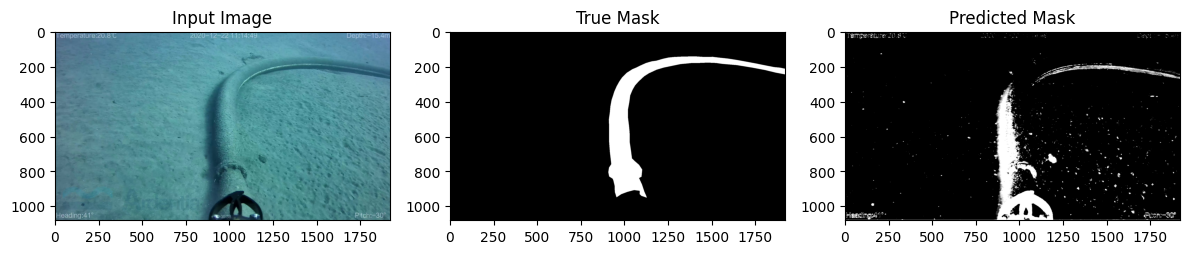

In [47]:
import matplotlib.pyplot as plt

model.eval()
img, true_mask = dataset[20]  # use any index
img_input = img.unsqueeze(0).to(device)

with torch.no_grad():
    pred_mask = model(img_input)
    pred_mask = torch.sigmoid(pred_mask)
    pred_mask = (pred_mask > 0.5).float()

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(img.permute(1, 2, 0).cpu())  # input image
axs[0].set_title("Input Image")

axs[1].imshow(true_mask.squeeze().cpu(), cmap="gray")
axs[1].set_title("True Mask")

axs[2].imshow(pred_mask.squeeze().cpu(), cmap="gray")
axs[2].set_title("Predicted Mask")
plt.tight_layout()
plt.show()


In [46]:
def dice_coeff(pred, target, smooth=1.0):
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
